In [0]:
### WBGPS analysis functions
from wbgps.analysis import compute_rural_migration_stats_city
my_palette = sns.color_palette(['#ce343c','#EC8A61', '#89d4b4','#0081A7', '#72C9C8', '#547474', '#8a567a', '#743D55','#b25a97', '#efb953'])

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import col, desc, lit
from pyspark.sql import Window

spark.conf.set("spark.sql.shuffle.partitions", 1500)

start_baseline = '2020-02-01'
end_baseline = '2020-03-01'
start_date = '2020-02-01'
end_date = '2021-04-15'

results_dir = '/dbfs/mnt/Geospatial/results/veraset/'
admin_path = f'/mnt/Geospatial/admin/' # country specific admin files should be stored as "{admin_path}/{country}/admin.csv"
stop_path = '/mnt/Geospatial/results/veraset/'


bins_wealth = [0, 0.4, 0.8, 1]
bins_dist = [0, 0.4, 0.8, 1]

countries = ['ID', 'PH', 'BR', 'CO', 'MX', 'ZA']


c_dates = {'BR': '2021-05-16',
           'CO': '2021-05-16',
           'ID': '2021-05-16',
           'MX': '2021-05-16',
           'PH': '2021-05-16',
           'ZA': '2021-05-16',
           'AR': '2021-05-16'}

activity_level = 0.2

hw = 49
ww = 49
wa = 3600
mph = 0.2
mpw = 0.2

# smoothing window size
ma = 28

# weath-group names
labels_wealth = [x+' ('+str(int(bins_wealth[i]*100))+'%-'+str(int(bins_wealth[i+1]*100)) +'%)' for i, x in zip(range(len(bins_wealth)-1), ['Low', 'Medium', 'High'])]
labels_dist = [x+' ('+str(int(bins_dist[i]*100))+'%-'+str(int(bins_dist[i+1]*100)) +'%)' for i, x in zip(range(len(bins_dist)-1), ['Low', 'Medium', 'High'])]
# largest metropolis names
country_capitals = {'MX': 'Mexico City', 'BR': 'São Paulo', 'CO': 'Bogota', 'PH': 'Quezon City [Manila]', 'ID': 'Jakarta', 'ZA': 'Johannesburg', 'AR': 'GBuenos Aires'}


In [0]:
# initialize dictionary where to store results
results = {}
for country in countries:
    print(country)

    admins_by_country, admins_by_metro_area, pop_metro_areas = process_admin(country,admin_path)
    capital_geomid = admins_by_metro_area[admins_by_metro_area.metro_area_name == country_capitals[country]].geom_id.unique().tolist()
    durations_and_admins = compute_durations_and_admins(country, c_dates[country], stop_path, activity_level=activity_level, hw=hw, ww=ww, wa=wa, mph=mph, mpw=mpw)
    durations_and_admins.cache()
    out1 = compute_durations_normalized_by_wealth_home(durations_and_admins, admins_by_country, labels_wealth, bins_wealth)
    out2 = compute_durations_normalized_by_wealth_home_wealth_work(durations_and_admins, admins_by_country, labels_wealth, bins_wealth)
    results[(country, 't_home')] = output(out1, column='H')
    results[(country, 't_work')] = output(out1, column='W')
    results[(country, 't_other')] = output(out1, column='O')
    results[(country, 'rec')] = output(out1, column='R')
    results[(country, 'comms')] = output(out1, column='C')
    results[(country, 'comms_hw')] = output_hw(out2, column='C')
    results[(country, 't_work_hw')] = output_hw(out2, column='W')

    durations_and_admins.unpersist()
# save results
res2 = pd.DataFrame(columns=['state', 'measure',
                             'wealth_label_home', 'date', 'mean', 'sem'])
for key, res in results.items():
    res_tmp = res.reset_index().copy()
    res_tmp['state'], res_tmp['measure'] = key
    res2 = res2.append(res_tmp, ignore_index=True)

res2.to_csv(results_dir+'all_hw_weighted.csv')

In [0]:
ylabels = {'t_home': 'Time spent at home\n(relative change)', 't_home_capital': 'Time at home metro area\n(relative change)',
           't_other': 'Time at third places\n(relative change)', 't_other_capital': 'Time at third places\npeople living in metro area (relative change)',
           'rec': 'Share of people not\nleaving home (relative change)', 'rec_capital': 'Share of people not\nleaving home metro area (relative change)',
           't_work': 'Time spent at work\n(relative change)', 't_work_capital': 'Time at work metro area\n(relative change)',
           'comms': 'Share of commuters\n(relative change)', 'comms_capital': 'Share of commuters metro area\n(relative change)',
           't_work_hw': 'Time spent at work\n(relative change)', 't_work_hw_capital': 'Time at work metro area\n(relative change)',
           'comms_hw': 'Share of commuters\n(relative change)', 'comms_hw_capital': 'Share of commuters metro area\n(relative change)'}

titles = {'t_home': 'Time at home', 't_home_capital': 'Time at home metro area',
           't_other': 'Time at third places', 't_other_capital': 'Time at third places metro area',
           'rec': 'Home only', 'rec_capital': 'Home only metro area',
           't_work': 'Time at work', 't_work_capital': 'Time at work metro area',
           'comms': 'Commuters', 'comms_capital': 'Share of commuters metro area',
           't_work_hw': 'Time at work (low-income)', 't_work_hw_capital': 'Time at work metro area (low-income)',
           'comms_hw': 'Commuters (low-income)', 'comms_hw_capital': 'Share of commuters metro area (low-income)'}



results = pd.read_csv(results_dir+'all_hw_weighted.csv', parse_dates=[
                      'date'], usecols=['date', 'state', 'measure', 'wealth_label_home', 'mean', 'sem', 'wealth_label_work'])

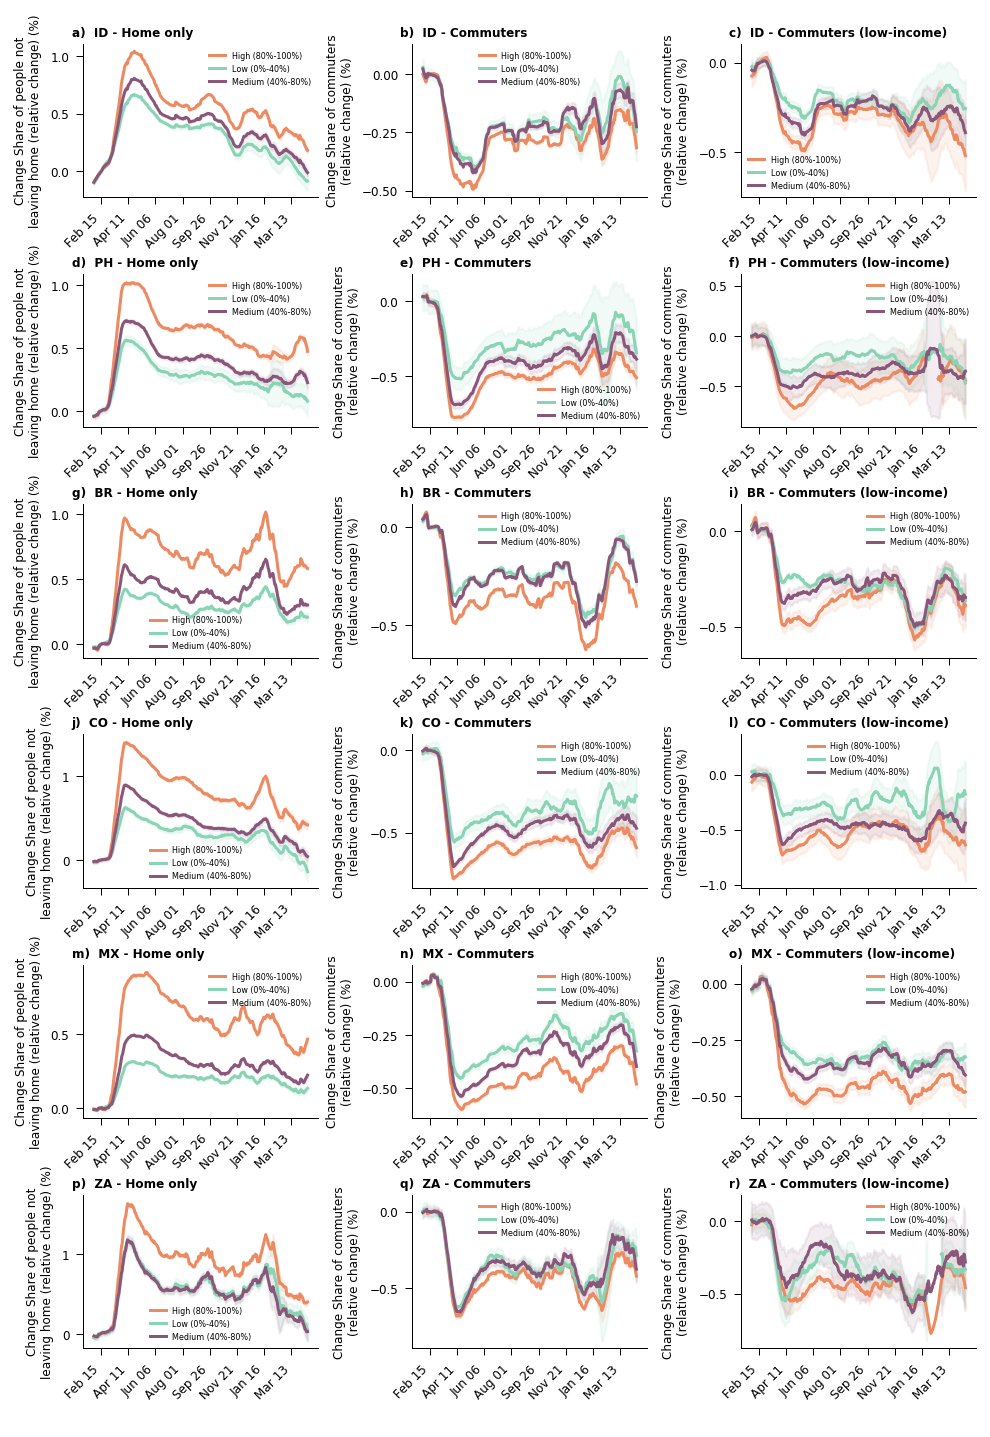

In [0]:
fig1, res1 = plot_metrics(results,results.state.unique(),other_groups=['wealth_label_home','wealth_label_work'],titles=titles)
fig1.savefig('/dbfs/FileStore/plots/mobility_patterns.pdf')
res1.to_csv('/dbfs/FileStore/tables/results_mobility_patterns_plot_data.csv',index=False)

In [0]:
### Summary statistics from plot:
##  1. average metric value before pandemic
##  2. average metric value during pandemic
##  3. max metric value during pandemic
##  4. final metric value (one week smoothed)
##  5. average metric difference high-low before
##  6. average metric difference high-low during
##  7. max. metric difference high-low
##  8. initial metric difference high-low
##  9. final metric difference high-low

# res1.loc[res1[res1['metric']=='rec'].index,labels_wealth] = -res1[res1['metric']=='rec'][labels_wealth]

stat1 = res1[res1['date']<=end_baseline].groupby(['state','metric']).mean()
stat2 = res1[(res1['date']>end_baseline)&(res1['date']<='2020-12-31')].groupby(['state','metric']).mean()
stat3 = res1[(res1['date']>end_baseline)].groupby(['state','metric']).min()[labels_wealth]
stat4 = res1.iloc[-7:].groupby(['state','metric']).mean()
diff = (res1[labels_wealth[2]]-res1[labels_wealth[0]]).to_frame('measure')
diff['state'] = res1['state']
diff['metric'] = res1['metric']
diff['date'] = res1['date']
diff['sem'] = np.sqrt(res1[labels_wealth[2]+'_StdErr']**2+res1[labels_wealth[0]+'_StdErr']**2)
stat5 = diff[diff['date']<=end_baseline][['measure','sem']].mean()
stat6 = diff[(diff['date']>end_baseline)&(diff['date']<='2020-12-31')].groupby('state')[['measure','sem']].mean()
stat7 = diff[(diff['date']>end_baseline)].groupby(['state','metric'])['measure'].min() # change from max to min if instead of the "rec" you want the maximum of the "comm"
stat8 = diff[(diff['date']<=end_baseline)].groupby(['state','metric'])[['measure','sem']].mean()
stat9 = diff[(diff['date']>end_baseline)].iloc[-7:].groupby(['state','metric']).mean()